In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 16
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 50, 500).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 51)
y_integers = y_dense[np.linspace(0, 499, 50, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/10).astype(int)
group_names = [f"第{i+1}组" for i in range(5)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5种不同颜色
for group in range(5):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=600,
    width=900,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.000999999999993465+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000 (应>0)


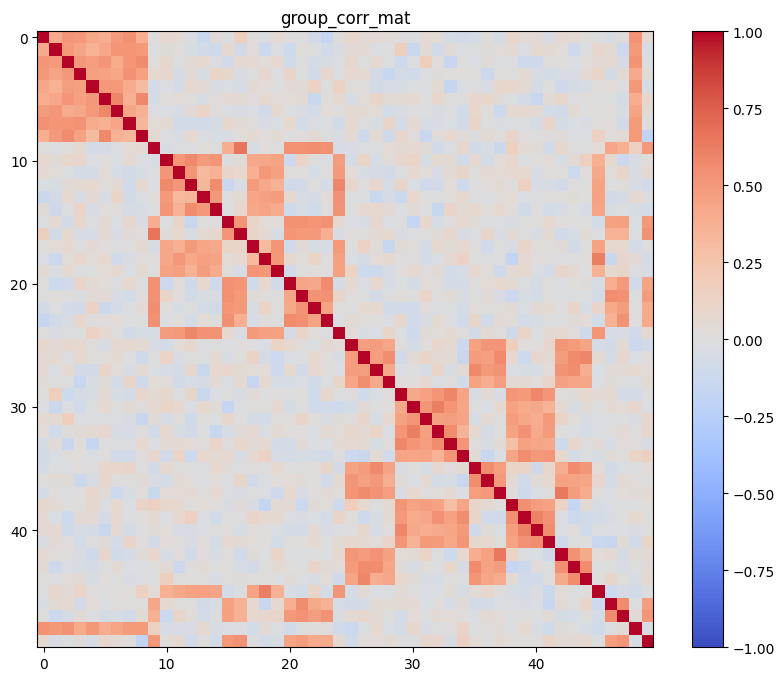

In [3]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 50
within_group_mean = 0.5
between_group_mean = 0.0
noise_std = 0.1 

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [4]:
group_labels+1

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4,
       4, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 3, 4, 4, 5, 4])

验证结果:
方差范围: 35.79-122.84 (目标: 25-144)
最小特征值: 0.000000 (应>0)


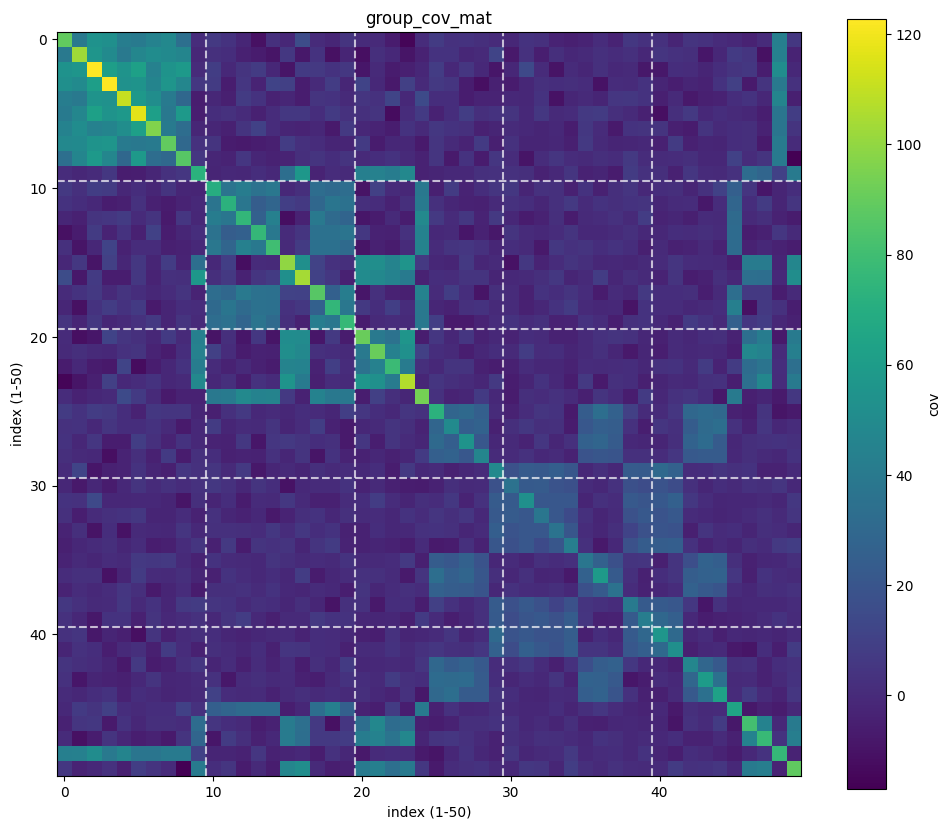

In [5]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [6]:
y_integers

array([75.44616156, 77.25407051, 78.50683255, 79.04677367, 78.80035755,
       77.86897598, 76.36672806, 74.79181161, 73.44890692, 72.37506676,
       71.74953507, 71.54116169, 71.55897899, 71.89385261, 72.28704233,
       72.53787081, 72.50854641, 72.28813787, 72.06099422, 72.0573384 ,
       72.39923452, 72.86819283, 73.15214935, 72.56462477, 71.20588697,
       69.46856607, 67.74486651, 66.48168939, 65.59911845, 65.1306763 ,
       64.76515706, 64.46775951, 64.36599738, 64.68992644, 65.09279787,
       65.62512195, 65.94201186, 65.86631685, 65.57142158, 65.16321933,
       64.95094293, 65.14705093, 66.00049684, 67.40034084, 69.37943112,
       71.11752078, 72.41286162, 73.18785872, 73.20355693, 73.13114394])

In [7]:
variances

array([ 89.10893943, 102.82317505, 122.8384925 , 122.42150857,
       110.49749135, 117.36766246,  96.46466028,  89.43454981,
        86.42982777,  72.28496843,  69.88062439,  72.71818071,
        75.65483038,  75.88343984,  79.85141846,  99.47735851,
       104.13424034,  86.48581984,  75.66960971,  76.77432349,
        91.13092102,  90.83448233,  78.44659752, 106.79510858,
        93.68190578,  72.96348223,  50.15124078,  55.04328572,
        46.75863906,  48.63170493,  35.80038059,  53.18923591,
        37.88197621,  36.10554483,  42.8538116 ,  37.88250425,
        59.33946394,  35.78838108,  40.13997115,  42.28137539,
        56.19995693,  52.80560956,  47.24874078,  59.92103769,
        62.8663863 ,  64.75371906,  81.10100975,  77.38226547,
        76.12795377,  88.46340875])